In [1]:
from IPython.display import HTML
from IPython.display import display
#Allows the reader to hide/show the code cells. From https://pastebin.com/H77xP2vN
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In this project the following questions are answered:
<ul>
    <li> How many companies are still in business ?</li>
    <li> How many investemnts went through ?</li>
    <li> What is the average amount of money invested ? How about the average % of equity shared ? </li>
    <li> Who are the most active investors ?</li>
    </ul>

Further investigation could look into:
<ul>
    <li> Which dragons have made the most investments per episode ? </li>
    <li> How well have the companies done after appearing on the show ?</li>
    <li> What company type is most commonly appearing on the show/ most likely to earn an investment ?</li>


In [2]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import numpy as np
import pandas as pd
import re
from pandas import Series, DataFrame
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline


In [3]:
url = 'https://www.tigermobiles.com/dragons-den/'

In [4]:
uClient = uReq(url) #openning up a connection, grabbing the page

In [5]:
page_html = uClient.read() #offloads the content into a variable
uClient.close() #close the file

In [6]:
page_soup = soup(page_html, 'lxml') # #the text needs to be parsed (as we have the raw html at the moment)

In [7]:
columns = page_soup.find('div', {'class': 'cols all-items'})#the part of the webpage containing a column of all companies

In [8]:
companies_info = columns.find_all('div',{'class':'dd-item-desc'})#a list of info for all individual companies

In [9]:
#Required data is:
#company name: h2
#investor name : div class 'dd-profile'
#series
#ivestment amount
#equity bought
#did the investment go through ?
#is the company still in bussiness ?

#In the future, could get the other data such as incorporation date as well

In [10]:
company_names = []
investors_list = []
show_series = []
investment_amount = []
equity_shared = []
investment_went_trhough = []
company_still_in_business = []


for company in companies_info:
    
    company_name = company.find('h2').text
    company_names.append(company_name)
    
    
    investors = company.find_all('div',{'class': 'dd-profile'})# there can be more than one investor
    # the name is in the form of 'FistLast', so to make it look better it's changed to 'First Last'
    investors_names =[]
    for investor in investors:
        investor = investor.text
        first_and_last = re.sub( r"([A-Z])", r" \1", investor).split()#split on capital letter
        investor_name = ' '.join(first_and_last)#join the names back into a string with a space between them
        investors_names.append(investor_name)
    investors_list.append(investors_names)
    
    
    # the last three h4 elements are the show's Series number, the investment amount and the equity% purchased
    details = company.find_all('span')[1:]#the first one is the names of the people appearing on the show
    series = details[0].text
    show_series.append(series)
    investment = details[1].text
    investment_amount.append(investment)
    equity = details[2].text
    equity_shared.append(equity)
    
    
    # the first two 'one-half' class divs are info on what happened after the show
    follow_up = company.find_all('div', {'class':'one-half'})[:2]

    #the answer to the question is in the form of an image with a specific div.
    icon_yes_0 = follow_up[0].find('div',{'class':'icon-yes'})# if the icon is no, the outpout is None

    if icon_yes_0:
        went_through ='Yes'
    else:
        went_through = 'No' 
    investment_went_trhough.append(went_through)

    icon_yes_1 = follow_up[1].find('div',{'class':'icon-yes'})

    if icon_yes_1:
        still_in_business ='Yes'
    else:
        still_in_business = 'No' 
    company_still_in_business.append(still_in_business)

In [11]:
df = DataFrame(list(zip(company_names,investors_list, show_series, investment_amount, 
                        equity_shared, investment_went_trhough, company_still_in_business)),
              columns =['company_name', 'investors_names', 'series','investment','equity','went_through','still_in_business'])

In [12]:
df.head()

,company_name,investors_names,series,investment,equity,went_through,still_in_business
0,Oatein Ltd,[Peter Jones],16,"£50,000",25%,No,Yes
1,Buddies Toothpaste,[],16,"£60,000",44%,No,Yes
2,Didsbury Gin,[Jenny Campbell],16,"£75,000",33%,Yes,Yes
3,Van De Sant Innovations,[Deborah Meaden],16,"£70,000",15%,No,Yes
4,OHMME,[Peter Jones],16,"£80,000",20%,No,Yes


investment and equity columns need to be changed to a number type

In [13]:
df.investment = df.investment.str.replace('£','').str.replace(',','') #get rid of sign and comma
df.investment = df.investment.astype(int) #change to integer type

In [14]:
df.equity = df.equity.map(lambda a: float(a[:-1])) #remove the '%' at the end of the string and change to float type

In [15]:
#in order to easily obtain a histogram which shows the series numbers in order, the type is converted from str to int

#there is an empty string value in the series list. As the rows next and before it are season 11, it'll be assumed that the '' 
#corresponds to 11
df.series[df.series.values == ''] = 11  

C:\Users\TotEu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
df.head()

,company_name,investors_names,series,investment,equity,went_through,still_in_business
0,Oatein Ltd,[Peter Jones],16,50000,25.0,No,Yes
1,Buddies Toothpaste,[],16,60000,44.0,No,Yes
2,Didsbury Gin,[Jenny Campbell],16,75000,33.0,Yes,Yes
3,Van De Sant Innovations,[Deborah Meaden],16,70000,15.0,No,Yes
4,OHMME,[Peter Jones],16,80000,20.0,No,Yes


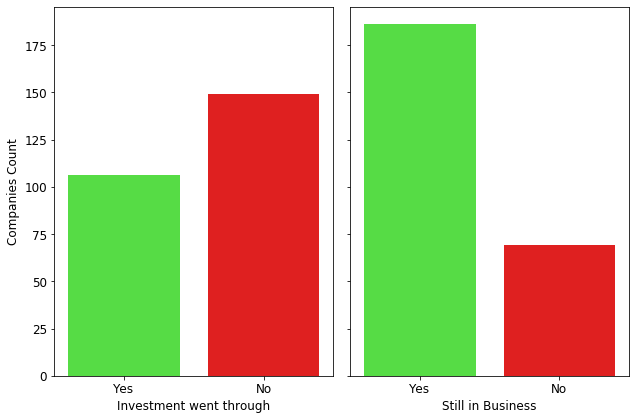

In [17]:
font = {'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

f, axes = plt.subplots(1, 2, figsize=(9, 6), sharey = True)

ax1 = sns.countplot('went_through', data=df, palette = ["#43f52c", "#ff0000"], ax = axes[0], order=["Yes","No"])
ax1.set(xlabel='Investment went through', ylabel='Companies Count')

ax2 = sns.countplot('still_in_business', data=df, palette =["#43f52c", "#ff0000"], ax =axes[1])
ax2.set(xlabel='Still in Business', ylabel='')


plt.setp(axes, yticks=[0,25,50, 75, 100, 125, 150, 175])
plt.tight_layout()

The majority of investments broke down following after-show negociations

In [18]:
s = df['went_through'].value_counts('No')*100
wentThrough = s['Yes']
print(f'Only {wentThrough:.2f} % went through')

Only 41.57 % went through


In [19]:
b = df['still_in_business'].value_counts('No')*100
inBusiness = b['Yes']
print(f'{inBusiness:.2f} % of commpanies were still active by the end of the 2019 series')

72.94 % of commpanies were still active by the end of the 2019 series


In [20]:
def investment_histogram(dataframe_, coords):

    #fig, ax  = plt.subplots()
    ax_invest = sns.distplot(dataframe_['investment'], kde_kws = {'color': 'k'},
                hist_kws = {'color':'green', 'alpha': 1}, ax = coords)#plot a histogram and a kernel density estimation
    ax_invest.set_xlabel('Pounds £')
     
    #code below deals with ticks positions and formating
    ax_invest.xaxis.set_ticks_position('bottom')
    ax_invest.yaxis.set_ticks_position('left')
    ax_invest.set_xlim(0,275000)

    ax_invest.tick_params(which='major', width=1.00, length=5)
    ax_invest.tick_params(which='minor', width=0.75, length=2.5)
    ax_invest.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
    ax_invest.xaxis.set_major_locator(ticker.MultipleLocator(50000))  
    
    ax_invest.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))#change x axis labels format from '10000' to '10,000'

In [21]:
def equity_histogram(dataframe_, coords):

    ax_equity = sns.distplot(dataframe_['equity'], kde_kws = {'color': 'k'},
                hist_kws = {'color':'b', 'alpha': 1}, ax = coords)#plot a histogram and a kernel density estimation
    ax_equity.set_xlabel('Equity')
    
    #code below deals with ticks positions and formating
    ax_equity.xaxis.set_ticks_position('bottom')
    ax_equity.yaxis.set_ticks_position('left')
    ax_equity.set_xlim(0,85)
    
    ax_equity.tick_params(which='major', width=1.00, length=5)
    ax_equity.tick_params(which='minor', width=0.75, length=2.5)
    ax_equity.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax_equity.xaxis.set_major_locator(ticker.MultipleLocator(10))
    
    ax_equity.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))# make x axis labels show % sign

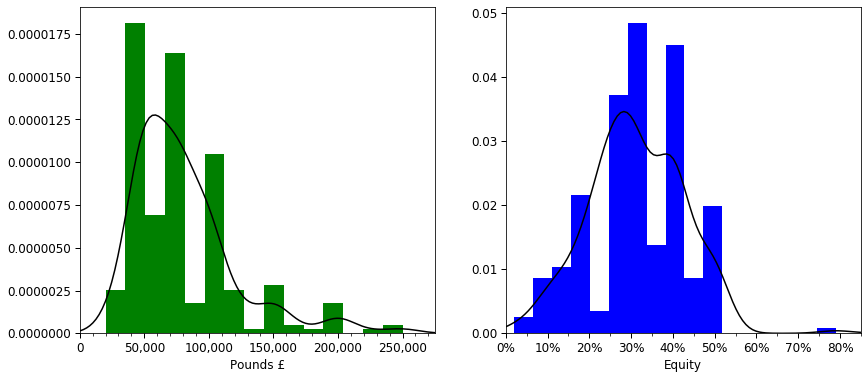

In [22]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))

investment_histogram(df, axes[0])
equity_histogram(df,axes[1])

In [23]:
df_invested = df[df.went_through == 'Yes'] # create a new data frame only containing data for investments that went through

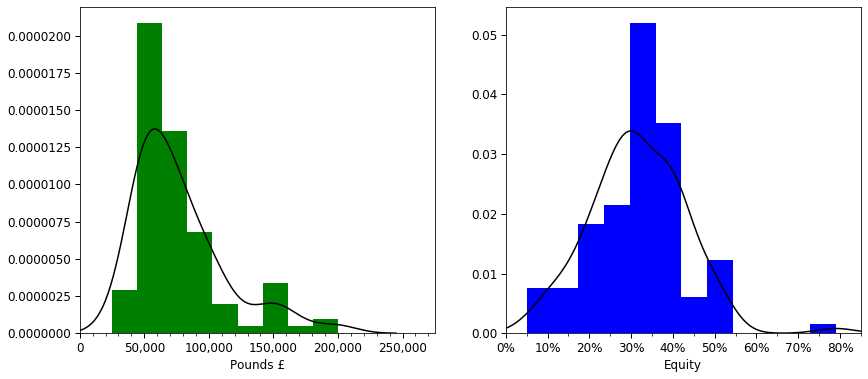

In [24]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))


investment_histogram(df_invested, axes[0])
equity_histogram(df_invested, axes[1])

In [25]:
#Printing the information of the largest investments.  
def print_max(df, column):
    to_print = pd.DataFrame()
    maximum = max(df[column])
    for i, amount in enumerate(df[column]): # not using argmax as there may be more than one maximum
        if amount == maximum:
            to_print = to_print.append(df.iloc[i])
    return to_print

print_max(df, 'investment')
#These print statements are hidden as they were just used to get some of the info for the description below    

,company_name,equity,investment,investors_names,series,still_in_business,went_through
136,Zapper,30.0,250000.0,[Theo Paphitis],10,Yes,No
205,DDN Ltd,25.0,250000.0,"[Deborah Meaden, Theo Paphitis]",6,Yes,No


In [26]:
#Largest investments that went through
print_max(df_invested, 'investment')

,company_name,equity,investment,investors_names,series,still_in_business,went_through
196,ProWaste Management Services,40.0,200000.0,"[Deborah Meaden, Duncan Bannatyne]",6,Yes,Yes
220,Gaming Alerts,30.0,200000.0,[Theo Paphitis],5,No,Yes


In [27]:
print_max(df_invested, 'equity')

,company_name,equity,investment,investors_names,series,still_in_business,went_through
151,RKA Records,79.0,50000.0,[Duncan Bannatyne],9,No,Yes


The investment amount and equity % curves follow approximately the same trend for investments made on the show and the deals that stood following after-show negociations.

Most investments are in the £40,000-60,000 range. £250,000 is the largest amount invested. 
There were two times when this sum was pledged, however in both situations the parties couldn't agree on a deal after the show. One investment was by Theo Paphitis in Zapper for 30% equity, while the other was made by Theo Paphitis and Deborah Meaden with DDN Ltd for 25% combined shares. Both companies were still in business by the end of 2019.

The largest completed investments were for 200,000 £. The first was made by Theo Paphitis in 2007 in Gaming Alerts for 30% equity. The company was dissolved in 2011 with Paphitis still holding a 30% share in the business. 
The second was made by Deborah Meaden and Duncan Bannatyne one year later for a shared 40% equity in ProWaste Management Services. 
Duncan and Deborah retired their positions as Directors in 2011.
 
Most common % equity sold lies in the 25-35% range. The overwhelming majority of entrepreneurs haven't sold more than 50% shares in their company. However there was one significant exception: in 2011 Duncan Bannatyne purchased 79% equity in RKA Records for 50,000 £. The investment went through and the company renamed itself Bannatyne Music Ltd with Duncan owning a 51% share in the business. It's still active at Companies House but is not running as a business.

In [28]:
#in order to plot the series in ascending order:
seasons_as_int = df.series.unique()[::-1]# get a list of individual series sorted
seasons = pd.Series(seasons_as_int).map(lambda a: str(a)).tolist() #turn values to string type

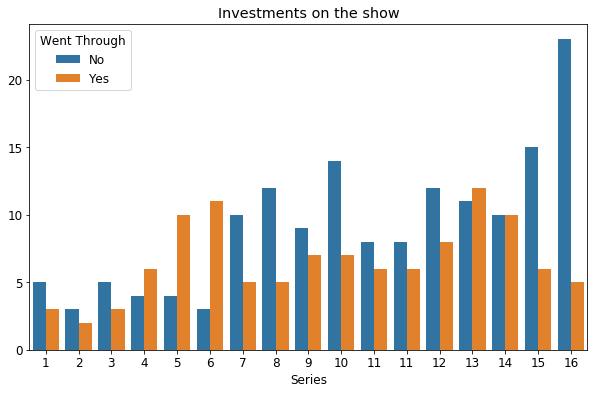

In [29]:
figure(figsize = (10,6))
f = sns.countplot('series', data=df, order = seasons, hue = 'went_through')
f.set_title('Investments on the show')
f.set_xlabel('Series')
f.set_ylabel('')
f.legend_.set_title('Went Through')
plt.close()
f.figure

In [30]:
df_15 = df[df.series == '15']
df_16 = df[df.series == '16']
df_last_two = df_15.append(df_16)

In [31]:
itwt = df_last_two['went_through'].tolist().count('Yes')# 11
tot = len(df_last_two)#48

In [32]:
df_6 = df[df.series == '6']

In [33]:
itwt_6 = df_6['went_through'].tolist().count('Yes') #11
tot_6 = len(df_6) #14

The general trend has been more and more investments per series, which can mostly be explained by the increase in number of episodes per series.

As expected, during the majority of series, most investments didn't go through. In series 15 and 16 especially, only 23% of investments were completed. The exceptions are series 4, 5, 6, 13 and 14. During the 6th series, 79% of investments went through. 

In [34]:
def get_names(df):
    names_list = df['investors_names'].tolist()#currently a list of lists of investors for each company

    #just a list of investors, which appear each time they were invested:
    flat_list = [investor for company in names_list for investor in company]

    #changing the names to appear shorter:
    shortened_names = []
    for n in flat_list:
        names = n.split(' ')
        names[0] = names[0][0]
        fin = '. '.join(names)
        shortened_names.append(fin)
    
    return shortened_names
shortened_names = get_names(df)

In [35]:
times_dict = {} # creating a dictionary with the investors and how many times they pledged an investment
for name in set(shortened_names):
    times_invested = shortened_names.count(name)
    d = {name: times_invested}
    times_dict.update(d)
    
    
ordered_names = sorted(times_dict.items(), key = 
             lambda kv:(kv[1], kv[0]), reverse = True)#sorting by number of pledges 


final_ordered_names = [] #get a list with names without the counts
for name in ordered_names:
    final_ordered_names.append(name[0])

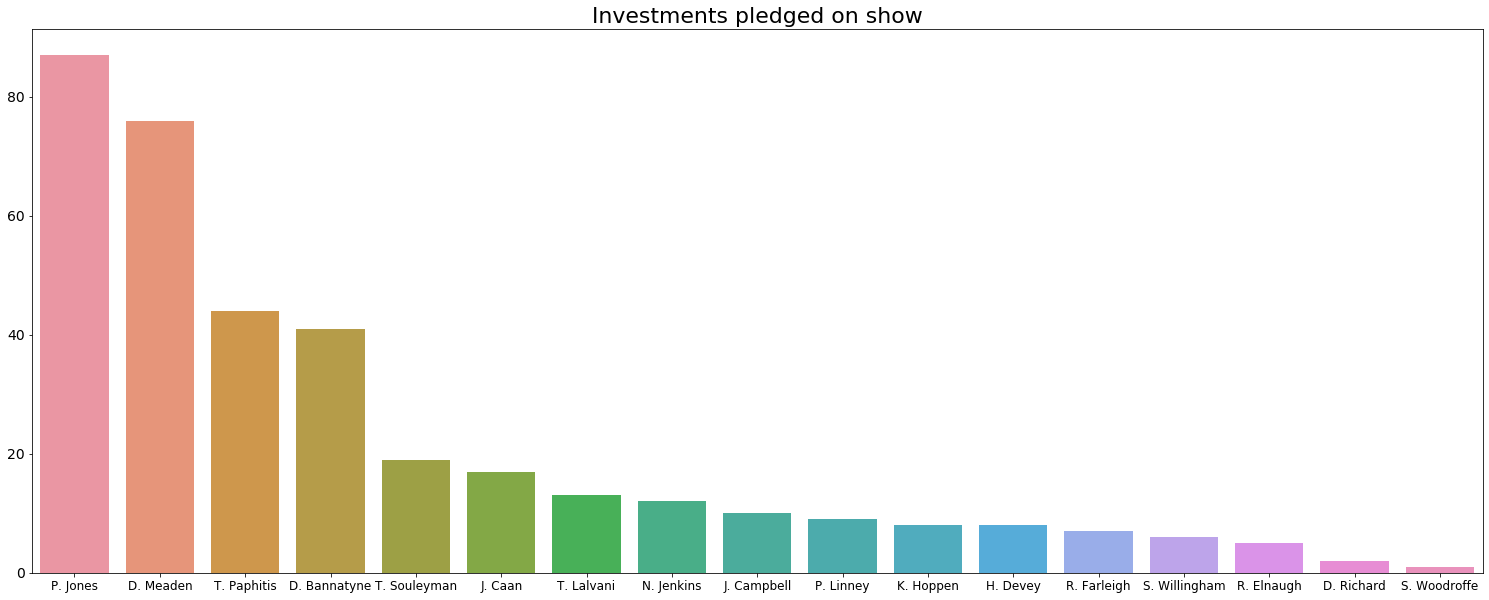

In [36]:
def investors_plot(names, title):

    plt.figure(figsize=(26,10))
    sns.countplot(names, order = final_ordered_names) #order by times pledged
    plt.title(title, fontsize = '22')
    plt.ylabel('')
    plt.yticks(fontsize = '14')
    plt.xticks(fontsize = '12')
    plt.show()
    

investors_plot(shortened_names, 'Investments pledged on show')

In [37]:
shortened_names_invested = get_names(df_invested)

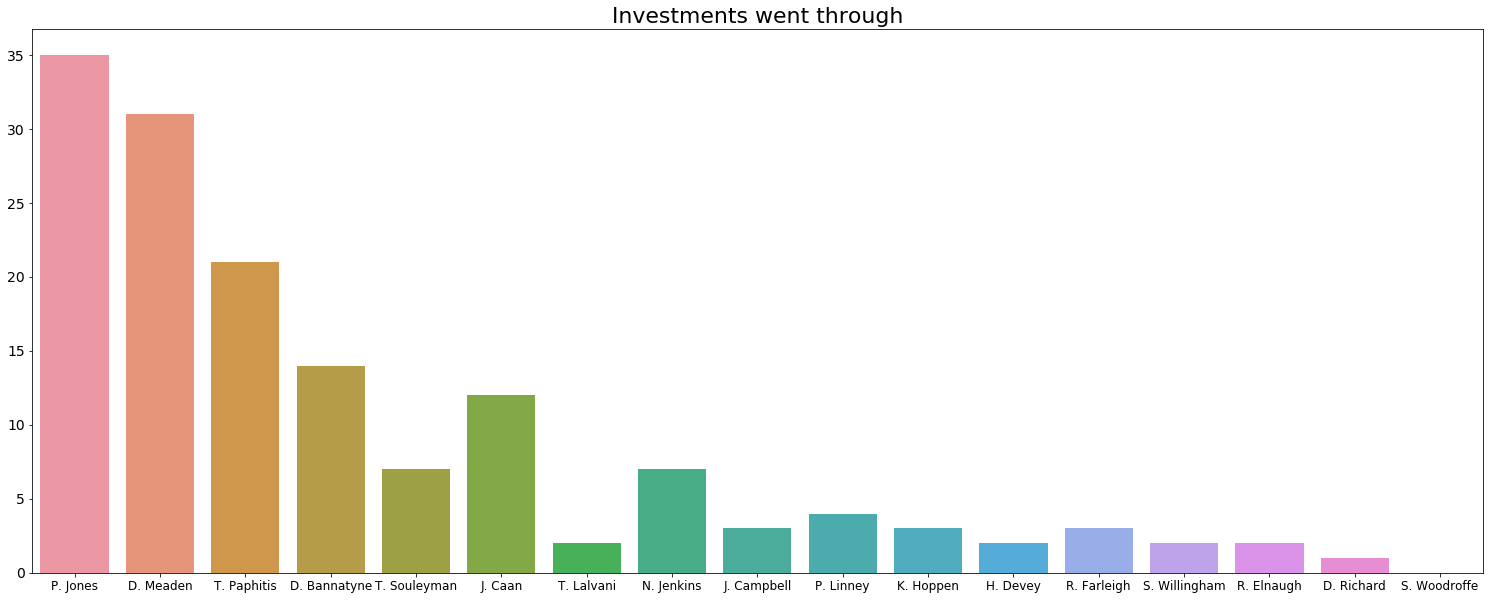

In [38]:
investors_plot(shortened_names_invested, 'Investments went through')

Peter Jones has has been the most prolific investor, having pledged 87 investments on the show. 
He also has the most investments that actually went through: 35; four more than Deborah Meaden.

This is to be expected as he is the only one who was part in all the 16 series.

Simon Woodroffe is the only dragon who hasn't had at least one investment go through.

In [39]:
total_sum_invested = sum(df['investment'])
print(f'In total, £{total_sum_invested} (£20.6 million) had been pledged by dragons at the end of the 16th series.')

In total, £20576200 (£20.6 million) had been pledged by dragons at the end of the 16th series.


In [40]:
sum_actually_invested = sum(df_invested['investment'])

In [41]:
invested_percent = sum_actually_invested/total_sum_invested*100

In [42]:
print (f'Out of that, only £{sum_actually_invested} (£8.2 million) ended up being invested, amounting to {invested_percent:.2f}%')

Out of that, only £8208000 (£8.2 million) ended up being invested, amounting to 39.89%


In [43]:
prev_report_percent = 5.8/13*100
print (f'This is a ~5% decrease from the tigermobiles findings, {prev_report_percent:.2f}% of the money invested had went through by the end of the 11th    series')

This is a ~5% decrease from the tigermobiles findings, 44.62% of the money invested had went through by the end of the 11th    series


In [44]:
times_dict_invested = {} # creating a dictionary with the investors and how many times they invested
for name in set(shortened_names):
    times_invested= shortened_names_invested.count(name)
    d = {name: times_invested}
    times_dict_invested.update(d)

In [45]:
# as the dictionaries have the same key order, the following code gets the %of times each investor went through with their
#offer 
percentages_dict = {}
for i in range(len(times_dict)):
    name = list(list(times_dict.items())[i])[0]# this gets a key from the dictionary by index 
    original_investments = list(list(times_dict.items())[i])[1] #gets the value
    actual_investments = list(list(times_dict_invested.items())[i])[1]
    percentage = actual_investments/original_investments*100
    d = {name:percentage}
    percentages_dict.update(d)

In [46]:
values = []
keyz=[]
for k,v in percentages_dict.items():# separate names and percentages
    values.append(v)
    keyz.append(k)

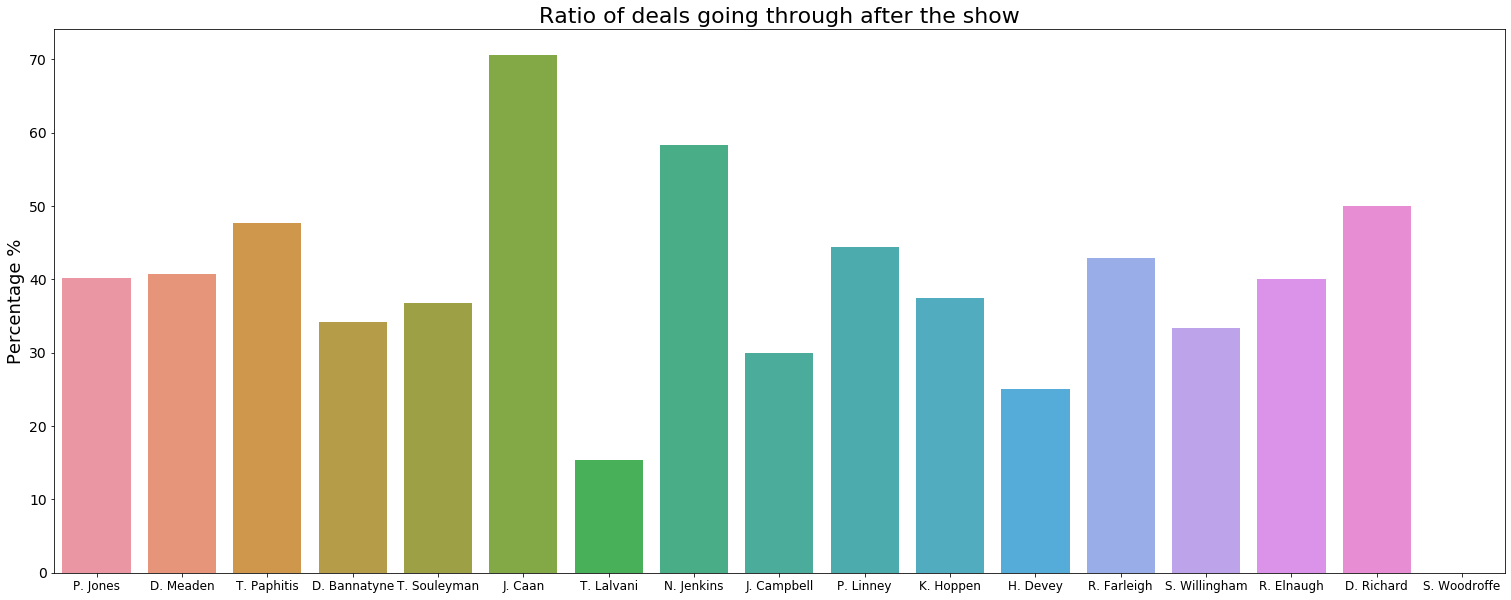

In [47]:
plt.figure(figsize=(26,10))
sns.barplot(keyz, values, order =final_ordered_names )
plt.title('Ratio of deals going through after the show', fontsize = '22')
plt.ylabel('Percentage %', fontsize = '18')
plt.yticks(fontsize = '14')
plt.xticks(fontsize = '12')
plt.show()

Tej Lalvani has been on the show since the 15th series. He has the lowest ratio of investments to pledged investments, 15%. Out of 13 initially agreed fundings, only 2 were followed through with, explaining the drastic decrease in the ratio for the past two seasons.